In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares

In [2]:
def model(x, u):
    return x[0] * (u ** 2 + x[1] * u) / (u ** 2 + x[2] * u + x[3])

def fun(x, u, y):
    return model(x, u) - y

def jac(x, u, y):
    J = np.empty((u.size, x.size))
    den = u ** 2 + x[2] * u + x[3]
    num = u ** 2 + x[1] * u
    J[:, 0] = num / den
    J[:, 1] = x[0] * u / den
    J[:, 2] = -x[0] * num * u / den ** 2
    J[:, 3] = -x[0] * num / den ** 2
    return J

In [3]:
u = np.array([4.0, 2.0, 1.0, 5.0e-1, 2.5e-1, 1.67e-1, 1.25e-1, 1.0e-1,
              8.33e-2, 7.14e-2, 6.25e-2])
y = np.array([1.957e-1, 1.947e-1, 1.735e-1, 1.6e-1, 8.44e-2, 6.27e-2,
              4.56e-2, 3.42e-2, 3.23e-2, 2.35e-2, 2.46e-2])
x0 = np.array([2.5, 3.9, 4.15, 3.9])
res = least_squares(fun, x0, jac=jac, bounds=(0, 100), args=(u, y), verbose=1)
print(res.x)

`ftol` termination condition is satisfied.
Function evaluations 130, initial cost 4.4383e+00, final cost 1.5375e-04, first-order optimality 4.92e-08.
[0.19280596 0.19130423 0.12306063 0.13607247]


In [5]:
import matplotlib.pyplot as plt

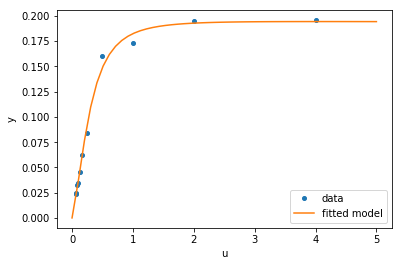

In [6]:
u_test = np.linspace(0, 5)
y_test = model(res.x, u_test)
plt.plot(u, y, 'o', markersize=4, label='data')
plt.plot(u_test, y_test, label='fitted model')
plt.xlabel("u")
plt.ylabel("y")
plt.legend(loc='lower right')
plt.show()

### Large-scale bundle adjustment in scipy

A bundle adjusmtent problem arises in 3-D reconstruction and it can be formulated as follows (taken from https://en.wikipedia.org/wiki/Bundle_adjustment):

Given a set of images depicting a number of 3D points from different viewpoints, bundle adjustment can be defined as the problem of simultaneously refining the 3D coordinates describing the scene geometry as well as the parameters of the relative motion and the optical characteristics of the camera(s) employed to acquire the images, according to an optimality criterion involving the corresponding image projections of all points.

More precisely. We have a set of points in real world defined by their coordinates (X,Y,Z) in some apriori chosen "world coordinate frame". We photograph these points by different cameras, which are characterized by their orientation and translation relative to the world coordinate frame and also by focal length and two radial distortion parameters (9 parameters in total). Then we precicely measure 2-D coordinates (x,y) of the points projected by the cameras on images. Our task is to refine 3-D coordinates of original points as well as camera parameters, by minimizing the sum of squares of reprojecting errors.

In [7]:
import urllib
import bz2
import os

In [8]:
BASE_URL = "http://grail.cs.washington.edu/projects/bal/data/ladybug/"
FILE_NAME = "problem-49-7776-pre.txt.bz2"
URL = BASE_URL + FILE_NAME

In [9]:
if not os.path.isfile(FILE_NAME):
    urllib.request.urlretrieve(URL, FILE_NAME)

In [10]:
def read_bal_data(file_name):
    with bz2.open(file_name, "rt") as file:
        n_cameras, n_points, n_observations = map(
            int, file.readline().split())

        camera_indices = np.empty(n_observations, dtype=int)
        point_indices = np.empty(n_observations, dtype=int)
        points_2d = np.empty((n_observations, 2))

        for i in range(n_observations):
            camera_index, point_index, x, y = file.readline().split()
            camera_indices[i] = int(camera_index)
            point_indices[i] = int(point_index)
            points_2d[i] = [float(x), float(y)]

        camera_params = np.empty(n_cameras * 9)
        for i in range(n_cameras * 9):
            camera_params[i] = float(file.readline())
        camera_params = camera_params.reshape((n_cameras, -1))

        points_3d = np.empty(n_points * 3)
        for i in range(n_points * 3):
            points_3d[i] = float(file.readline())
        points_3d = points_3d.reshape((n_points, -1))

    return camera_params, points_3d, camera_indices, point_indices, points_2d

In [11]:
camera_params, points_3d, camera_indices, point_indices, points_2d = read_bal_data(FILE_NAME)

Here we have numpy arrays:

1. camera_params with shape (n_cameras, 9) contains initial estimates of parameters for all cameras. First 3 components in each row form a rotation vector (https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula), next 3 components form a translation vector, then a focal distance and two distortion parameters.
1. points_3d with shape (n_points, 3) contains initial estimates of point coordinates in the world frame.
1. camera_ind with shape (n_observations,) contains indices of cameras (from 0 to n_cameras - 1) involved in each observation.
1. point_ind with shape (n_observations,) contatins indices of points (from 0 to n_points - 1) involved in each observation.
1. points_2d with shape (n_observations, 2) contains measured 2-D coordinates of points projected on images in each observations.

In [12]:
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]

n = 9 * n_cameras + 3 * n_points
m = 2 * points_2d.shape[0]

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters: {}".format(n))
print("Total number of residuals: {}".format(m))

n_cameras: 49
n_points: 7776
Total number of parameters: 23769
Total number of residuals: 63686


Now define the function which returns a vector of residuals. We use numpy vectorized computations:

In [13]:
def rotate(points, rot_vecs):
    """
        Rotate points by given rotation vectors.

        Rodrigues' rotation formula is used.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis]
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return cos_theta * points + sin_theta * np.cross(v, points) + dot * (1 - cos_theta) * v

In [14]:
def project(points, camera_params):
    """
        Convert 3-D points to 2-D by projecting onto images.
    """
    points_proj = rotate(points, camera_params[:, :3])
    points_proj += camera_params[:, 3:6]
    points_proj = -points_proj[:, :2] / points_proj[:, 2, np.newaxis]
    f = camera_params[:, 6]
    k1 = camera_params[:, 7]
    k2 = camera_params[:, 8]
    n = np.sum(points_proj**2, axis=1)
    r = 1 + k1 * n + k2 * n**2
    points_proj *= (r * f)[:, np.newaxis]
    return points_proj

In [15]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """
    Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return (points_proj - points_2d).ravel()

You can see that computing Jacobian of fun is cumbersome, thus we will rely on the finite difference approximation. 

To make this process time feasible we will use Jacobian sparsity structure (i. e. mark elements which are known to be non-zero):

In [16]:
from scipy.sparse import lil_matrix

def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.size * 2
    n = n_cameras * 9 + n_points * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1

    return A

Now we are ready to run optimization. Let's visualize residuals evaluated with the initial parameters.

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

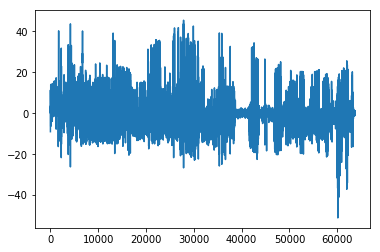

In [18]:
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)
plt.plot(f0)
plt.show()

In [19]:
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)

In [20]:
import time
from scipy.optimize import least_squares

In [21]:
t0 = time.time()
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.5091e+05                                    8.57e+06    
       1              3         5.0985e+04      8.00e+05       1.46e+02       1.15e+06    
       2              4         1.6077e+04      3.49e+04       2.59e+01       2.43e+05    
       3              5         1.4163e+04      1.91e+03       2.86e+02       1.21e+05    
       4              7         1.3695e+04      4.67e+02       1.32e+02       2.51e+04    
       5              8         1.3481e+04      2.14e+02       2.24e+02       1.54e+04    
       6              9         1.3436e+04      4.55e+01       3.18e+02       2.73e+04    
       7             10         1.3422e+04      1.37e+01       6.82e+01       2.19e+03    
       8             11         1.3418e+04      3.68e+00       1.26e+02       7.82e+03    
       9             12         1.3414e+04      4.15e+00       2.64e+01       6.26e+02    

In [22]:
print("Optimization took {0:.0f} seconds".format(t1 - t0))

Optimization took 51 seconds


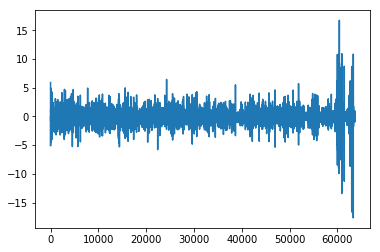

In [23]:
plt.plot(res.fun)